In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, LeaveOneOut, KFold

In [7]:
water = pd.read_csv("site_snow.csv")
months = ["Jan","Feb","Mar"]

#RATIO of Jan, Feb, Mar to April
water["Snow Ratio"] = water[months].sum(axis=1).div(water["Apr"] + .001)


water_2 = pd.get_dummies(water, columns=['Site_Name', 'County'])

y = water_2["Apr"] + .001
y = y.fillna(0.001)
X = water_2.drop(["Apr","Apr (WE)","May", "May (WE)", "Jun", "Jun (WE)"], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)

In [9]:
water_2["Snow Ratio"]

0        1.787062
1        3.707861
2        9.598533
3        1.568371
4       20.489755
          ...    
3985     2.281179
3986     3.304204
3987     2.882183
3988     4.466369
3989     1.760831
Name: Snow Ratio, Length: 3990, dtype: float64

In [10]:
water_3 = water_2.drop("Snow Ratio", axis = 1)

### RANDOM FOREST REGRESSOR Jan, Feb, Mar Snow to Apr Snow Feature



In [366]:
# Define preprocessing steps for numeric and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rounder', FunctionTransformer(np.round, validate=False)),  # Round numeric features
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a Random Forest Regressor pipeline
rf_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor(max_depth=20, n_estimators=100))])

# Train the model
rf_regressor.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('rounder',
                                                                   FunctionTransformer(func=<function round at 0x000001EFD9611BB0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Elev', 'Lat', 'Lon', 'installed', 'Water Year', 'Jan', 'Jan (WE)',
       'Feb', 'Feb (WE)', 'Mar', 'Mar (WE)', 'Snow Ratio'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('regressor', RandomForestRegressor(max_depth=20))])

In [367]:
rf_y_pred = rf_regressor.predict(X_test)
print("Random Forest Regressor R2 Score:",r2_score(y_test, rf_y_pred))
print("Random Forest Regressor MAE :",mean_absolute_error(y_pred=rf_y_pred,y_true=y_test))
print("Random Forest Regressor MSE:",mean_squared_error(y_pred=rf_y_pred,y_true=y_test))
print("Random Forest Regressor RMSE:",np.sqrt(mean_squared_error(y_pred=rf_y_pred,y_true=y_test)))

y_train_pred = rf_regressor.predict(X_train)

# Calculate the training MSE
training_mse = mean_squared_error(y_train, y_train_pred)
print("Random Forest Regressor Training MSE:", training_mse)
rf_regressor.score(X_train,y_train)

Random Forest Regressor R2 Score: 0.9653968418805235
Random Forest Regressor MAE : 3.6905398668884053
Random Forest Regressor MSE: 28.950324526263884
Random Forest Regressor MSE: 5.380550578357561
Random Forest Regressor Training MSE: 5.845250646711936


0.99304395018164

In [13]:
months = ["Jan","Feb","Mar"]
water_3["Snow to Elevation"] = water_3[months].sum(axis=1).div(water_3["Elev"])

y = water_3["Apr"] + .001
y = y.fillna(0.001)
X = water_3.drop(['Apr', 'Apr (WE)', 'May', 'May (WE)', 'Jun', 'Jun (WE)'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)


### Random Forest Regressor Snow to Elevation Feature


In [14]:

# Define preprocessing steps for numeric and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rounder', FunctionTransformer(np.round, validate=False)),  # Round numeric features
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a Random Forest Regressor pipeline
rf_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor(random_state=42))])

# Param grid search and running rf model
hyperparameter_grid = {
    'regressor__n_estimators': [50, 100, 300, 500],
    # 'regressor__max_leaf_nodes': [4, 8, 16, 32],
    'regressor__max_depth': [1, 3, 5, 10, 15, 20]
    }

rs = RandomizedSearchCV(rf_regressor, param_distributions=hyperparameter_grid, scoring='neg_mean_squared_error', cv=6)
rs.fit(X_train, y_train)


RandomizedSearchCV(cv=6,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('rounder',
                                                                                                FunctionTransformer(func=<function round at 0x000001706784E670>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Elev', 'Lat', 'Lon', 'installed', 'Water Year', 'Jan', 'Jan (WE)',
       'Feb', 'Feb (WE)...
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               Index([], dtype='object'))])),
                                             ('regressor',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'regressor__max_depth': [1, 3, 5, 10,
                                                                 15, 20],
                                        'regressor__n_estimators': [50, 100,
                                                                    300, 500]},
                   scoring='neg_mean_squared_error')

In [15]:
rs.best_params_

{'regressor__n_estimators': 300, 'regressor__max_depth': 20}

In [16]:
rf_y_pred = rs.predict(X_test)
print("Random Forest Regressor R2 Score:",r2_score(y_test, rf_y_pred))
print("Random Forest Regressor MAE :",mean_absolute_error(y_pred=rf_y_pred,y_true=y_test))
print("Random Forest Regressor MSE:",mean_squared_error(y_pred=rf_y_pred,y_true=y_test))
print("Random Forest Regressor RMSE:",np.sqrt(mean_squared_error(y_pred=rf_y_pred,y_true=y_test)))

y_train_pred = rs.predict(X_train)

# Calculate the training MSE
training_mse = mean_squared_error(y_train, y_train_pred)
print("Random Forest Regressor Training MSE:", training_mse)
rs.score(X_train,y_train)

Random Forest Regressor R2 Score: 0.9101740502098836
Random Forest Regressor MAE : 6.3724169033045035
Random Forest Regressor MSE: 75.15182251067597
Random Forest Regressor RMSE: 8.669015083080428
Random Forest Regressor Training MSE: 12.557745736948938


-12.557745736948938

In [17]:
rs.best_est = rs.best_estimator_

feature_importance = rs.best_est.named_steps['regressor'].feature_importances_
sorted_idx = feature_importance.argsort()[::-1]
sorted_idx


array([10,  9,  4,  0,  7,  5,  8,  2,  1,  3,  6, 11], dtype=int64)

In [18]:
sorted_feature_names=[]

for index in sorted_idx:
    sorted_feature_names.append(water.iloc[:, index].name)
    print(water.iloc[:, index].name)


Feb (WE)
Feb
installed
Site_Name
Jan
County
Jan (WE)
Lat
Elev
Lon
Water Year
Mar


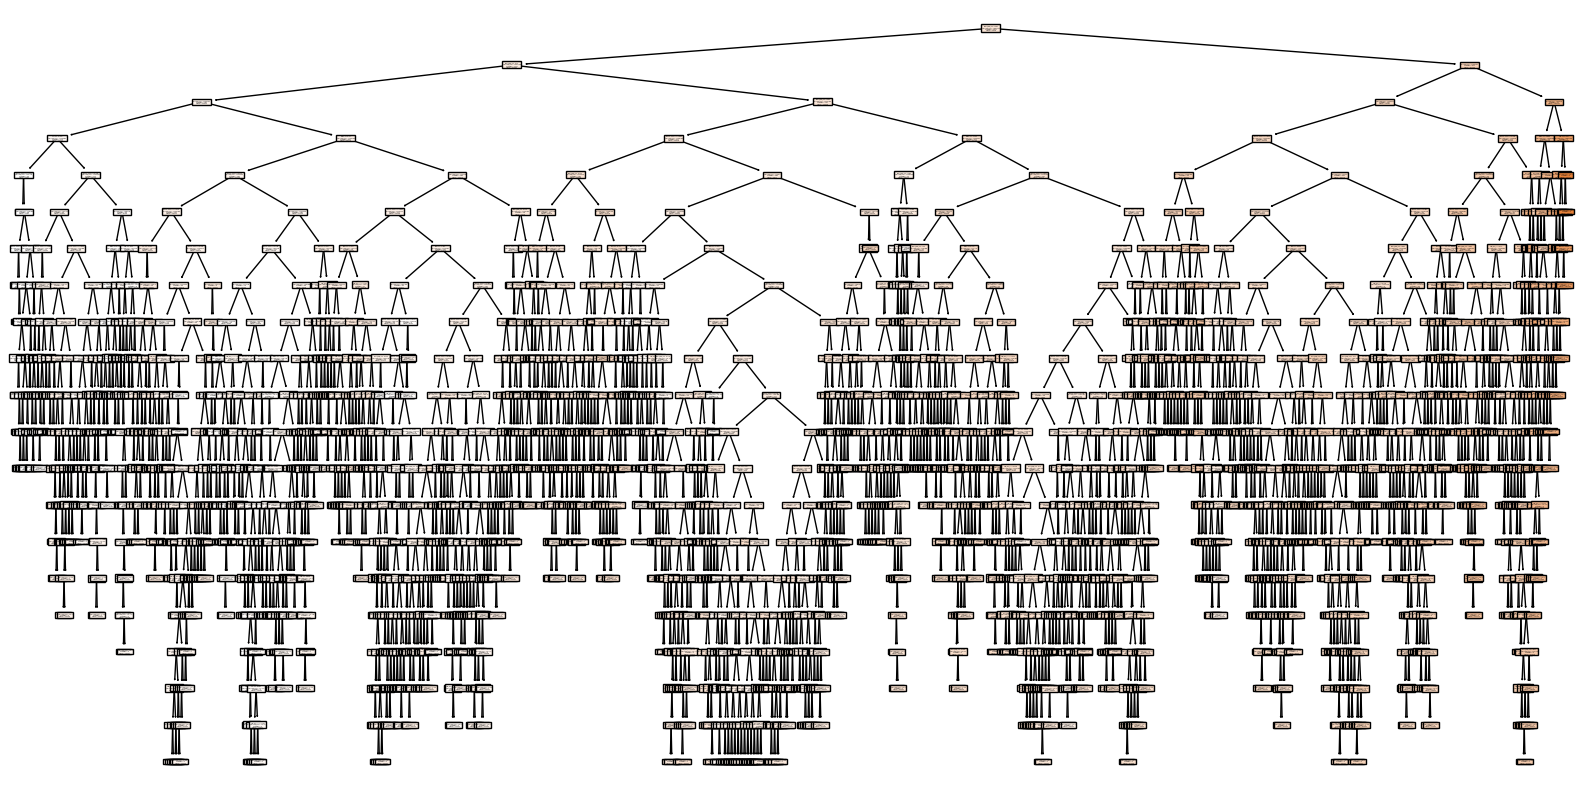

In [373]:
import sklearn.tree as tree

tree_to_visualize = rf_regressor.named_steps['regressor'].estimators_[0]

# Visualize the tree
plt.figure(figsize=(20, 10))
tree.plot_tree(tree_to_visualize, filled=True, feature_names=numeric_features.tolist() + categorical_features.tolist())
plt.show()

### LASSO REGRESSION

In [374]:
## Lasso Model

# X['Water Year'] = X['Water Year'].astype(object)
# X['installed'] = X['installed'].astype(object)

numeric_cols = X.select_dtypes(include=['float64']).columns
X[numeric_cols] = X[numeric_cols].round(4)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

lasso = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', Lasso(alpha=.01))])

In [375]:
fitted_model = lasso.fit(X_train,y_train)

In [376]:
lasso_y_pred = fitted_model.predict(X_test)

print("Lasso R2 :",r2_score(y_test, lasso_y_pred))
print("Lasso MAE :",mean_absolute_error(y_pred=lasso_y_pred,y_true=y_test))
print("Lasso MSE:",mean_squared_error(y_pred=lasso_y_pred,y_true=y_test))
print(f'Lasso RMSE : {np.sqrt(mean_squared_error(y_pred=lasso_y_pred,y_true=y_test))}')
fitted_model.score(X_train,y_train)


Lasso R2 : 0.8441959135656352
Lasso MAE : 8.449878271121154
Lasso MSE: 130.35165314157075
Lasso RMSE : 11.417164846912334


0.8231558845269767

In [377]:
names =fitted_model.named_steps['regressor']

names.coef_

sorted_idx = np.argsort(feature_importance)[::-1]

# Get the names of the most important features
feature_names = X_train.columns
most_important_features = feature_names[sorted_idx]

print("Most important features:")
for i in range(10):  # Print the top 10 most important features
    print(f"{i+1}. {most_important_features[i]}")

Most important features:
1. Mar (WE)
2. Mar
3. Water Year
4. Elev
5. Feb
6. Jan
7. Feb (WE)
8. Lon
9. Lat
10. installed


### SUPPORT VECTOR REGRESSOR

In [378]:
from sklearn.svm import SVR

numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', SVR(kernel='linear', C=4))])

svm_pipeline.fit(X_train, y_train)

svm_y_pred = svm_pipeline.predict(X_test)

mse = mean_squared_error(y_test, svm_y_pred)
r2 = r2_score(y_test, svm_y_pred)
mae = mean_absolute_error(y_test,svm_y_pred)

print(f'SVM Mean Squared Error: {mse}')
print(f'SVM R-squared: {r2}')
print(f'SVM MAE:  {mae}')
print(f'SVM RMSE : {np.sqrt(mse)}')
svm_pipeline.score(X_train,y_train)


SVM Mean Squared Error: 133.28510127329648
SVM R-squared: 0.8406896810380757
SVM MAE:  8.406352640964263
SVM RMSE : 11.544916685420318


0.8202922882063184

### KNN REGRESSOR

In [379]:
from sklearn.neighbors import KNeighborsRegressor

numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Add the KNN regressor to the pipeline
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', KNeighborsRegressor(n_neighbors=7))])

# Train the model
knn_pipeline.fit(X_train, y_train)

# Make predictions
knn_y_pred = knn_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, knn_y_pred)
r2 = r2_score(y_test, knn_y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'RMSE : {np.sqrt(mse)}')

Mean Squared Error: 124.7210497337987
R-squared: 0.8509259472773625
RMSE : 11.167857884742208


### SHAP: RF REGRESSOR Snow Elev Feature

Text(0.5, 1.0, 'Random Forest Feature Importances')

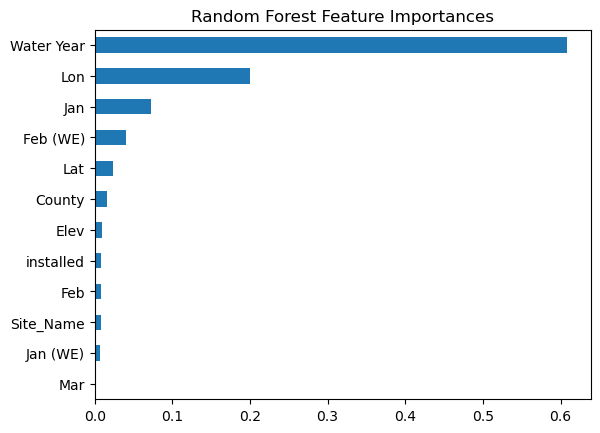

In [19]:
# Feature importances
pd.Series(rs.best_est.named_steps['regressor'].feature_importances_, 
          index=sorted_feature_names).sort_values().plot.barh()
plt.title('Random Forest Feature Importances')

In [20]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [47]:
# SHAP values for training data
rf_regressor = rs.best_est.named_steps['regressor']
explainer = shap.TreeExplainer(rf_regressor)

# It runs for fewer observations (possibly due to number of features) so should run it on 
#   a subset of X_test and the analyze using individual observations
sv = explainer(X_test)

In [48]:
# Should produce 2 dimensions as regression model
sv.shape

(798, 172)

In [83]:
# exp = shap.Explanation(sv[0], sv.base_values[0], X, feature_names=sorted_feature_names)
exp = shap.Explanation(sv, sv.base_values, X, feature_names=sorted_feature_names)

In [88]:
exp.shape

(798, 172)

In [103]:
selected_feature_names = exp[0].feature_names[:8]

shap.waterfall_plot(selected_feature_names, selected_shap_values[:8])

12

In [89]:
selected_features = ['Water Year', 'Lon', 'Jan']  # Define the features you want to include

# Get the index of the sample you want to plot
sample_index = 0  # Change this to the index of the specific sample you want to plot

shap_values_sample = exp[sample_index].values
base_value_sample = exp[sample_index].base_values

In [90]:
selected_shap_values = [shap_values_sample[exp.feature_names.index(feature)] for feature in selected_features]
selected_feature_names = selected_features